# Sessa Empirical Estimator

This notebook implements the Sessa Empirical Estimator to preprocess event intervals and applies clustering using:
- **K-Means**: Finds the optimal number of clusters using silhouette scores.
- **DBSCAN**: A density-based clustering algorithm with dynamic epsilon (`eps`) selection.

_Each step has been encapsulated into **callable functions** as per the given additional task._

---

## Implementation

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

### Load dataset

In [2]:
def load_dataset(filepath):
    data = pd.read_csv(filepath)
    data.columns = ["PATIENT_ID", "DATE", "DURATION", "PERDAY", "CATEGORY", "CATEGORY_L1", "CATEGORY_L2"]
    data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
    return data

filepath = 'med_events_ATC.csv'
data = load_dataset(filepath)

display(data.head())

,PATIENT_ID,DATE,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2
0,1,2057-09-04,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
1,1,2058-06-03,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
2,1,2058-07-09,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
3,1,2056-10-09,41.666667,36000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES"
4,1,2056-12-10,40.000000,36000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES"


### Explore `CATEGORY` counts

In [3]:
def explore_categories(data, min_data_points=20):
    category_counts = data['CATEGORY'].value_counts()
    print("CATEGORY Counts:\n", category_counts)
    
    if not category_counts[category_counts >= min_data_points].empty:
        selected_category = category_counts[category_counts >= min_data_points].index[0]
        print(f"Automatically selected CATEGORY: {selected_category}")
        return selected_category
    else:
        raise ValueError("No CATEGORY meets the minimum data point requirement.")

selected_category = explore_categories(data)

CATEGORY Counts:
 CATEGORY
A09AA02    251
A11HA03    160
J01FA10    119
A11CC05    107
A02BC05     78
R05CB13     76
A05AA02     75
B02BA01     74
R03AC02     64
J01XB01     63
J02AC02     62
J01EE01     41
R03AK06     40
A02BC01     38
J01GB01     33
R03DC03     32
R03AK07     30
A11CA01     26
J01MA02     26
R03AC12     23
A10BX02     20
R03DX05     19
J01AA08     19
A10AB05     18
A10AE04     17
J01DF01     12
A12AX       10
R03BA05      7
J01DD13      4
J01FG01      4
A02BC02      3
R03AK08      3
J02AC03      3
J01CR02      2
A10AD05      2
R03AL04      1
A11CC01      1
J02AC04      1
Name: count, dtype: int64
Automatically selected CATEGORY: A09AA02


### Calculate Event Intervals

In [4]:
def calculate_event_intervals(data, selected_category, percentile_cutoff=80):
    filtered_data = data[data['CATEGORY'] == selected_category]
    print(f"Filtered data size for CATEGORY '{selected_category}': {len(filtered_data)}")

    # sort and calculate intervals
    filtered_data = filtered_data.sort_values(by=['PATIENT_ID', 'DATE'])
    filtered_data['prev_DATE'] = filtered_data.groupby('PATIENT_ID')['DATE'].shift(1)
    filtered_data['event_interval'] = (filtered_data['DATE'] - filtered_data['prev_DATE']).dt.days
    filtered_data = filtered_data.dropna(subset=['prev_DATE'])
    
    if len(filtered_data) < 3:
        raise ValueError("Not enough data points for clustering. Adjust filter or CATEGORY selection.")

    # ECDF and threshold
    event_intervals = filtered_data['event_interval']
    threshold = np.percentile(event_intervals, percentile_cutoff)
    filtered_intervals = event_intervals[event_intervals <= threshold]
    print(f"Threshold (80th Percentile): {threshold}")
    print(f"Number of intervals below threshold: {len(filtered_intervals)}")

    return filtered_data, filtered_intervals, threshold

filtered_data, filtered_intervals, threshold = calculate_event_intervals(data, selected_category)

display(filtered_data[['PATIENT_ID', 'event_interval']].head())

Filtered data size for CATEGORY 'A09AA02': 251
Threshold (80th Percentile): 42.80000000000001
Number of intervals below threshold: 189


,PATIENT_ID,event_interval
4,1,62.0
5,1,64.0
6,1,11.0
7,1,1.0
8,1,67.0


### K-Means Clustering

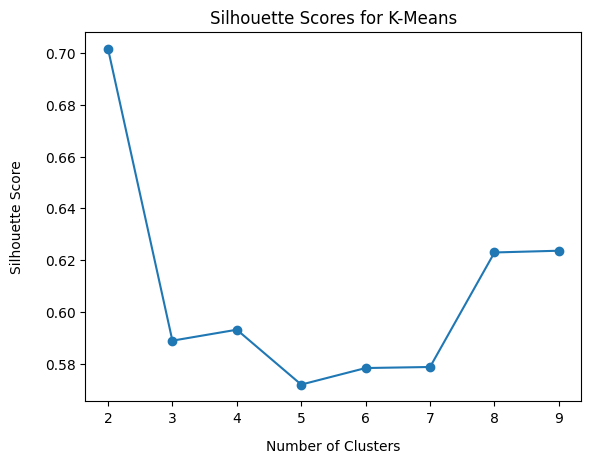

Optimal number of clusters (K): 2


In [5]:
def perform_kmeans(X):
    best_k = 2
    best_score = -1
    silhouette_scores = []
    for k in range(2, min(10, len(X))):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)
        if score > best_score:
            best_k = k
            best_score = score
    
    plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o')
    plt.title("Silhouette Scores for K-Means")
    plt.xlabel("Number of Clusters", labelpad=10)
    plt.ylabel("Silhouette Score", labelpad=15)
    plt.show()
    
    print(f"Optimal number of clusters (K): {best_k}")
    kmeans = KMeans(n_clusters=best_k, random_state=42).fit(X)
    return kmeans, best_k

X = np.array(filtered_intervals).reshape(-1, 1)
kmeans, best_k = perform_kmeans(X)
filtered_data['kmeans_cluster'] = kmeans.predict(np.array(filtered_data['event_interval']).reshape(-1, 1))

### DBSCAN Clustering

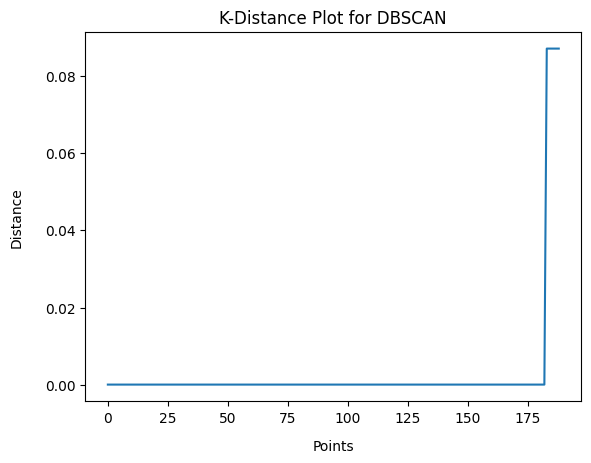

Selected eps value for DBSCAN: 0.08719411619417239
Number of clusters formed by DBSCAN (excluding noise): 23


In [6]:
def perform_dbscan(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    neighbors = NearestNeighbors(n_neighbors=2)
    neighbors_fit = neighbors.fit(X_scaled)
    distances, _ = neighbors_fit.kneighbors(X_scaled)
    sorted_distances = np.sort(distances[:, 1])
    
    plt.plot(sorted_distances)
    plt.title("K-Distance Plot for DBSCAN")
    plt.xlabel("Points", labelpad=10)
    plt.ylabel("Distance", labelpad=15)
    plt.show()
    
    elbow_index = np.argmax(np.diff(sorted_distances)) + 1
    eps_value = sorted_distances[elbow_index]
    print(f"Selected eps value for DBSCAN: {eps_value}")
    
    dbscan = DBSCAN(eps=eps_value, min_samples=3).fit(X_scaled)

    # to handle edges cases where no clusters are formed
    if len(set(dbscan.labels_)) <= 1:
        print("DBSCAN did not form any clusters (only noise detected).")
        
    return dbscan

dbscan = perform_dbscan(X)
dbscan_labels = pd.Series(dbscan.labels_, index=filtered_intervals.index)
filtered_data['dbscan_cluster'] = dbscan_labels.reindex(filtered_data.index, fill_value=-1)

# to calculate number of clusters
unique_clusters = np.unique(dbscan.labels_)
num_clusters = len(unique_clusters[unique_clusters != -1])  # Exclude noise (-1)
print(f"Number of clusters formed by DBSCAN (excluding noise): {num_clusters}")

### Visualizations for clustering results

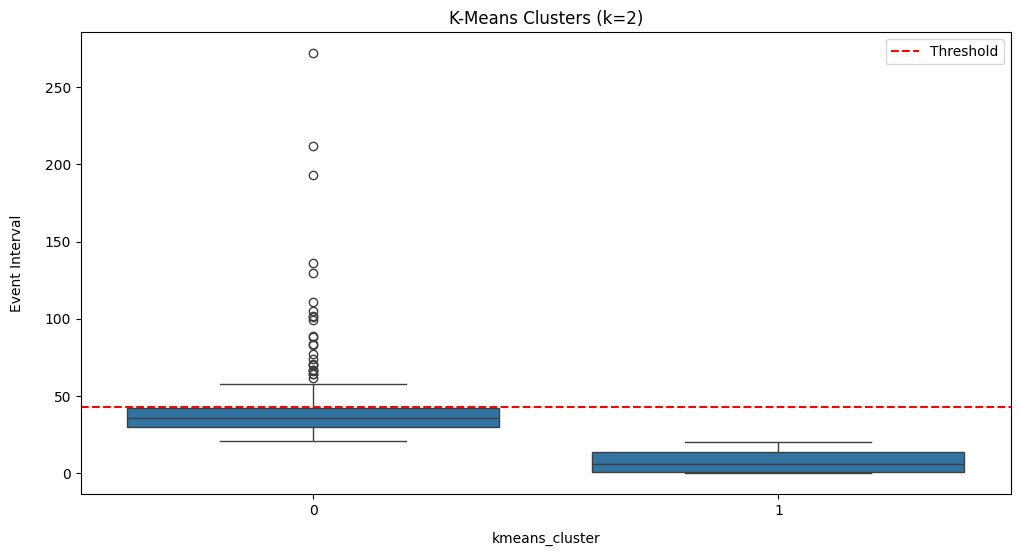

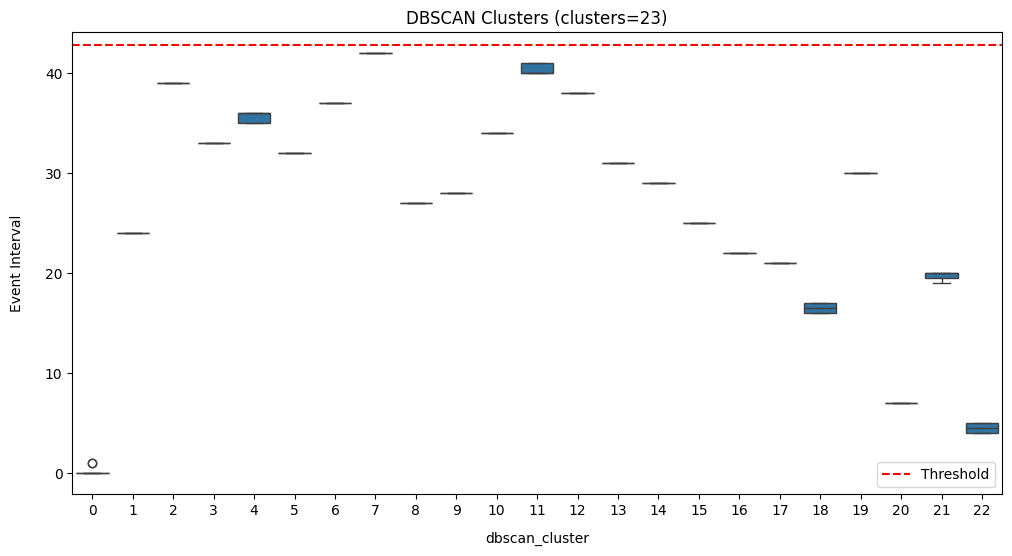

In [7]:
def plot_clusters(data, cluster_col, title, threshold=None):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=cluster_col, y='event_interval', data=data[data[cluster_col] != -1])
    if threshold:
        plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
    plt.title(title)
    plt.ylabel("Event Interval", labelpad=15)
    plt.xlabel(cluster_col, labelpad=10)
    plt.legend()
    plt.show()

plot_clusters(filtered_data, 'kmeans_cluster', f"K-Means Clusters (k={best_k})", threshold)

plot_clusters(filtered_data, 'dbscan_cluster', f"DBSCAN Clusters (clusters={num_clusters})", threshold)

### DBSCAN noise

In [8]:
noise_percentage = (dbscan.labels_ == -1).sum() / len(dbscan.labels_) * 100
print(f"Percentage of noise points: {noise_percentage:.2f}%")

Percentage of noise points: 7.94%


---

## Insights from DBSCAN clustering

### 1. Noise Detection
- DBSCAN identified 7.94% of the data points as noise (-1 cluster). This highlights the presence of outliers or irregular patterns in the dataset that K-Means does not account for.

### 2. Cluster shapes
- Unlike K-Means, which assumes spherical clusters, DBSCAN forms clusters with irregular shapes. This is especially useful for datasets with unevenly distributed data points.

### 3. Comparison with K-Means
- K-Means formed 2 clusters, while DBSCAN formed 22 clusters (excluding noise). The difference highlights DBSCAN's flexibility in grouping data points based on density rather than predefined cluster counts.

The clustering results from DBSCAN suggest that the dataset contains inherent noise or outliers, and the clusters are not strictly spherical. This may provide a better understanding of the data patterns, especially for irregularly occurring events.